## 1. Standard Import

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
#import torch.nn as nn
import torch.nn.functional  as F
from scipy.signal import convolve2d

# To read an image from URL
import imageio.v2 as imageio

## First Approach :  Manual Convolution

In [4]:
# image : random 20x20 image
imgN = 20
image = np.random.randn(imgN,imgN)

# Convolution kernel or Image filter (7x7 kernel)
kernelN = 7
Y,X = np.meshgrid(np.linspace(-3,3,kernelN),np.linspace(-3,3,kernelN))
kernel = np.exp( -(X**2+Y**2)/7 )

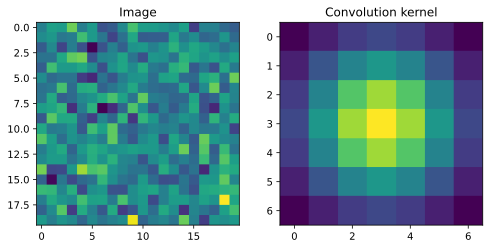

In [5]:
# let's see what they look like
fig,ax = plt.subplots(1,2, figsize=(8,6),  dpi=135)

ax[0].imshow(image)
ax[0].set_title('Image')

ax[1].imshow(kernel)
ax[1].set_title('Convolution kernel')

plt.show()

#### Manual convolution Code

In [6]:
imgN = 20
kernelN = 7
# returns the quotient
halfKr = kernelN//2

convoutput = np.zeros((imgN,imgN))

for rowi in range(0, imgN-kernelN+1):
#     print(f"Rows :    {rowi}:{rowi+kernelN}")
    for coli in range(0,imgN-kernelN+1):

        # cut out a piece of the image
        # Extracting required rows and columns
        pieceOfImg = image[rowi:rowi+kernelN, coli:coli+kernelN]      
        
        # dot product: element-wise multiply and sum (and flip the kernel for "real convolution")
        dotprod = np.sum( pieceOfImg*kernel[::-1,::-1] )

        # store the result for this pixel
        convoutput[halfKr+rowi, halfKr+coli] = dotprod
        
        
#         print(f"Columns : {coli}:{coli+kernelN}")
#         print()

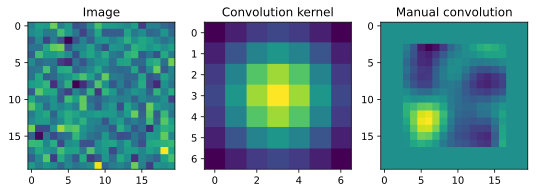

In [7]:
fig,ax = plt.subplots(1,3,figsize=(9,4))

ax[0].imshow(image)
ax[0].set_title('Image')

ax[1].imshow(kernel)
ax[1].set_title('Convolution kernel')

ax[2].imshow(convoutput)
ax[2].set_title('Manual convolution')

plt.show()

## Second Approach :  Using Scipy

In [8]:
# mode : valid 
# The output consists only of those elements that do not rely on the zero-padding.
convoutput2 = convolve2d(image,kernel,mode='valid')

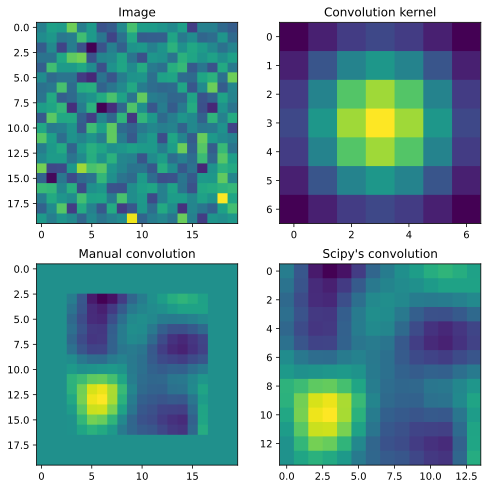

In [9]:
fig,ax = plt.subplots(2,2,figsize=(8,8), dpi=135)

ax[0,0].imshow(image)
ax[0,0].set_title('Image')

ax[0,1].imshow(kernel)
ax[0,1].set_title('Convolution kernel')

ax[1,0].imshow(convoutput)
ax[1,0].set_title('Manual convolution')

ax[1,1].imshow(convoutput2)
ax[1,1].set_title("Scipy's convolution")

plt.show()

## Convolution on Real-world image

In [10]:
# Examples of convolution with different kernels in a real image

# Read a pic from the web
bathtub = imageio.imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')

# check the size
print(bathtub.shape)

# height = 1675
# width = 3000
# 3rd dimension is the RGB channel

(1675, 3000, 3)


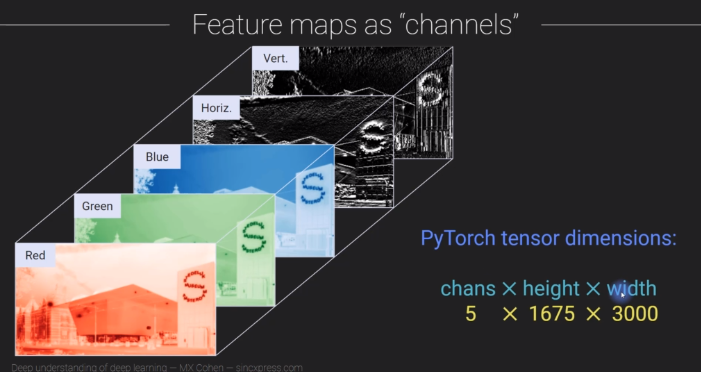

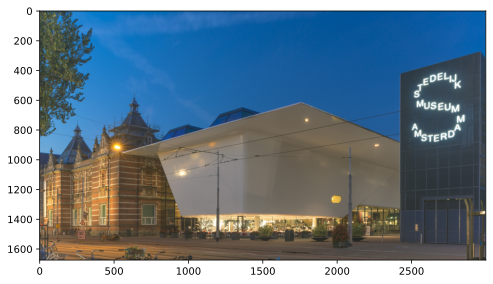

In [11]:
# let's see what the famous Bathtub Museum looks like
fig = plt.figure(figsize=(8,6), dpi=135)
plt.imshow(bathtub);

In [12]:
# Transform image to 2D for convenience (not necessary for convolution!)
bathtub_tr = np.mean(bathtub,axis=2)
bathtub_tr = bathtub_tr/np.max(bathtub)

# check the size again
print(bathtub_tr.shape)

(1675, 3000)


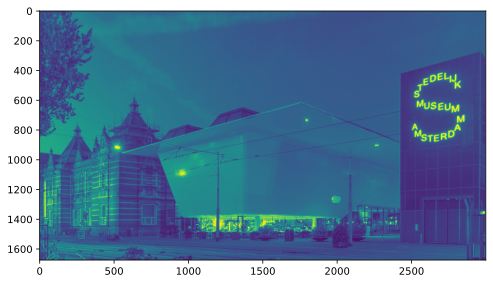

In [13]:
fig = plt.figure(figsize=(8,6), dpi=135)
plt.imshow(bathtub_tr)
plt.show()

#### Hand-craft two convolution kernels

In traditional image processing, it's important to have Kernel sum to zero<br>
because that prevents the Kernel itself from adding an offset to the result of convolution.

But, in DL we actually donot need to worry about that (it doesn't matter)<br>
because of bias term (each Kernel has its own bias term).

In [14]:
# vertical kernel
VK = np.array([ [1,0,-1],
                [1,0,-1],
                [1,0,-1] ])

# horizontal kernel
HK = np.array([ [ 1, 1, 1],
                [ 0, 0, 0],
                [-1,-1,-1] ])

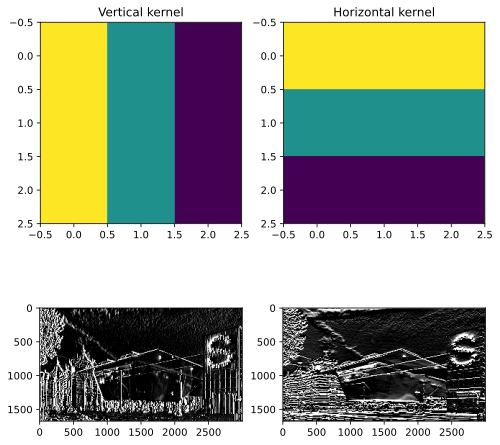

In [15]:
fig,ax = plt.subplots(2,2,figsize=(8,8))

ax[0,0].imshow(VK)
ax[0,0].set_title('Vertical kernel')

ax[0,1].imshow(HK)
ax[0,1].set_title('Horizontal kernel')


# run convolution and show the result
convres = convolve2d(bathtub_tr,VK,mode='same')
ax[1,0].imshow(convres,cmap='gray',vmin=0,vmax=.01)

convres = convolve2d(bathtub_tr,HK,mode='same')
ax[1,1].imshow(convres,cmap='gray',vmin=0,vmax=.01)

plt.show()

## Third Approach :  Using Pytorch

### STEP1 : convert numpy array into tensor

In [16]:
# first, translate everything into a tensor

# Reshaping 
# starting from left to right
# 1 : number of images in a batch
# 1 : number of channels (1 means gray-intensity channel)
# 3 : height
# 3 : width

VK_t = torch.tensor(VK).view(1,1,3,3).double()
HK_t = torch.tensor(HK).view(1,1,3,3).double()
bathtub_t = torch.tensor(bathtub_tr).view(1,1,bathtub.shape[0],bathtub.shape[1])

print(VK_t.shape)
print(bathtub_t.shape)

torch.Size([1, 1, 3, 3])
torch.Size([1, 1, 1675, 3000])


In [17]:
C_v = F.conv2d(bathtub_t,VK_t)
C_h = F.conv2d(bathtub_t, HK_t)

print(C_v.shape)
print(C_h.shape)

torch.Size([1, 1, 1673, 2998])
torch.Size([1, 1, 1673, 2998])


In [18]:
C_v

tensor([[[[-0.1307,  0.1608,  0.1373,  ...,  0.0275, -0.0353, -0.0131],
          [-0.1490,  0.0314,  0.2863,  ...,  0.0209, -0.0052, -0.0209],
          [-0.0314,  0.0288,  0.2288,  ...,  0.0275,  0.0052,  0.0013],
          ...,
          [ 0.0523,  0.0078, -0.0261,  ...,  0.0013, -0.0052,  0.0235],
          [ 0.0353, -0.0013,  0.0157,  ...,  0.0105,  0.0013,  0.0235],
          [-0.0288, -0.0431,  0.0601,  ...,  0.0039,  0.0118,  0.0118]]]],
       dtype=torch.float64)

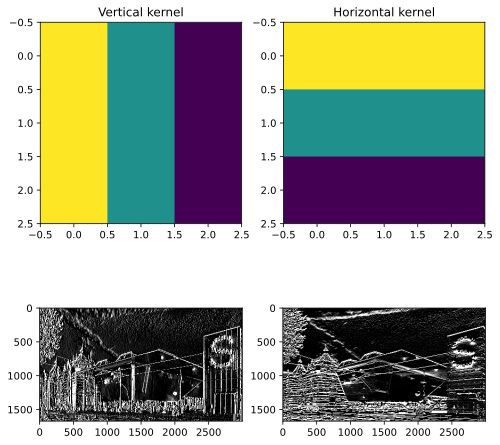

In [20]:
fig,ax = plt.subplots(2,2,figsize=(8,8), dpi=135)

ax[0,0].imshow(VK)
ax[0,0].set_title('Vertical kernel')

ax[0,1].imshow(HK)
ax[0,1].set_title('Horizontal kernel')


# run convolution and show the result
# torch.squeeze : Returns a tensor with all the dimensions of 'input' of size '1' removed.
img_v = torch.squeeze(C_v.detach())
ax[1,0].imshow(img_v,cmap='gray',vmin=0,vmax=.01)

img_h = torch.squeeze(C_h.detach())
ax[1,1].imshow(img_h,cmap='gray',vmin=0,vmax=.01)

plt.show()